In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

## 使用加利福尼亚的房价数据

In [3]:
from sklearn.datasets.california_housing import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




In [5]:
len(housing.feature_names)

8

In [6]:
print(housing.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [7]:
housing.data.shape

(20640, 8)

In [8]:
# 每个数据有 8 个维度
housing.data[0]

array([   8.3252    ,   41.        ,    6.98412698,    1.02380952,
        322.        ,    2.55555556,   37.88      , -122.23      ])

<b><font size='5' color='ff0000'>liwei 补充：决策树在使用的时候不用特征标准化，因为没有使用距离作为度量。</font></b>

In [10]:
housing.target

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

## 因为是回归问题，所以使用 `Regressor` 类

In [11]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=2)

X = housing.data[:, [6, 7]]
y = housing.target
dtr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [17]:
from sklearn import tree

# 要可视化显示 首先需要安装 graphviz http://www.graphviz.org/Download..php
dot_data = tree.export_graphviz(
    dtr,
    out_file=None,
    feature_names=housing.feature_names[6:8],
    filled=True,
    impurity=False,
    rounded=True
)

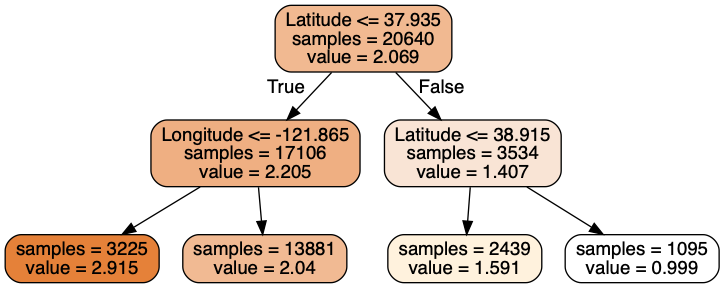

In [18]:
# pip install pydotplus
import pydotplus
graph = pydotplus.graph_from_dot_data(dot_data)
graph.get_nodes()[7].set_fillcolor("#FFF2DD")

from IPython.display import Image
Image(graph.create_png())

In [19]:
graph.write_png("dtr_white_background.png")

True

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X = housing.data
y = housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=42)
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train, y_train)

dtr.score(X_test, y_test)

0.637318351331017

In [21]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.7908649228096493

## 树模型参数:

-  1.criterion  gini  or  entropy

-  2.splitter  best or random 前者是在所有特征中找最好的切分点 后者是在部分特征中（数据量大的时候）

-  3.max_features  None（所有），log2，sqrt，N  特征小于50的时候一般使用所有的

-  4.max_depth  数据少或者特征少的时候可以不管这个值，如果模型样本量多，特征也多的情况下，可以尝试限制下

-  5.min_samples_split  如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。

-  6.min_samples_leaf  这个值限制了叶子节点最少的样本数，如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝，如果样本量不大，不需要管这个值，大些如10W可是尝试下5

-  7.min_weight_fraction_leaf 这个值限制了叶子节点所有样本权重和的最小值，如果小于这个值，则会和兄弟节点一起被剪枝默认是0，就是不考虑权重问题。一般来说，如果我们有较多样本有缺失值，或者分类树样本的分布类别偏差很大，就会引入样本权重，这时我们就要注意这个值了。

-  8.max_leaf_nodes 通过限制最大叶子节点数，可以防止过拟合，默认是"None”，即不限制最大的叶子节点数。如果加了限制，算法会建立在最大叶子节点数内最优的决策树。如果特征不多，可以不考虑这个值，但是如果特征分成多的话，可以加以限制具体的值可以通过交叉验证得到。

-  9.class_weight 指定样本各类别的的权重，主要是为了防止训练集某些类别的样本过多导致训练的决策树过于偏向这些类别。这里可以自己指定各个样本的权重如果使用“balanced”，则算法会自己计算权重，样本量少的类别所对应的样本权重会高。

- 10.min_impurity_split 这个值限制了决策树的增长，如果某节点的不纯度(基尼系数，信息增益，均方差，绝对差)小于这个阈值则该节点不再生成子节点。即为叶子节点 。
- n_estimators:要建立树的个数

# 使用网格搜索找到最佳超参数

GridSearchCV 中的 CV 是超参数的意思，这个操作很耗时。

In [22]:
%%time
from sklearn.model_selection import GridSearchCV

tree_param_grid = {
    'min_samples_split': [3, 6, 9],
    'n_estimators': [10, 50, 100]
}

grid = GridSearchCV(RandomForestRegressor(), param_grid=tree_param_grid, cv=5)
grid.fit(X_train, y_train)


CPU times: user 3min 28s, sys: 1.74 s, total: 3min 30s
Wall time: 3min 31s


In [23]:
grid.cv_results_

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*wa

{'mean_fit_time': array([0.84882808, 4.20971785, 8.52669249, 0.78972039, 3.99763546,
        7.87351584, 0.76177578, 3.90962539, 7.61334991]),
 'mean_score_time': array([0.00994782, 0.05007672, 0.10344148, 0.00865526, 0.04088969,
        0.07924314, 0.00764942, 0.03950911, 0.07006202]),
 'mean_test_score': array([0.78775731, 0.80412995, 0.80658756, 0.7901256 , 0.80529143,
        0.80714507, 0.78702384, 0.80370702, 0.8059165 ]),
 'mean_train_score': array([0.95813677, 0.96886652, 0.96997366, 0.94656732, 0.95679786,
        0.95786563, 0.93419335, 0.94358299, 0.94492931]),
 'param_min_samples_split': masked_array(data=[3, 3, 3, 6, 6, 6, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10, 50, 100, 10, 50, 100, 10, 50, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False],
    

In [26]:
grid.best_params_, grid.best_score_

({'min_samples_split': 6, 'n_estimators': 100}, 0.80714506563246)

In [30]:
%%time
rfr = RandomForestRegressor(min_samples_split=6, n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

CPU times: user 10.2 s, sys: 73.9 ms, total: 10.2 s
Wall time: 10.3 s


In [31]:
pd.Series(rfr.feature_importances_, index=housing.feature_names).sort_values(ascending=False)

MedInc        0.532536
AveOccup      0.138034
Latitude      0.089992
Longitude     0.088810
HouseAge      0.052888
AveRooms      0.042798
Population    0.028066
AveBedrms     0.026876
dtype: float64

参考资料：GridSearchCV。